In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
#from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
train = pd.read_csv('train_housePrice.csv')
test = pd.read_csv('test_housePrice.csv')
sample_submission = pd.read_csv('sample_submission_housePrice.csv')

In [3]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Number of observations in train and test sets are nearly equal - bad, but still

In [6]:
y_train = train.SalePrice
test_id = test['Id']

train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

df = pd.concat([train, test], axis=0).reset_index(drop=True)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## Fill Categorical Missing Values

In [7]:
cat_cols_1 = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

cat_cols_2 = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
              'MasVnrType', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']

df[cat_cols_1] = df[cat_cols_1].fillna("None")

for i in cat_cols_2:
    df[i] = df[i].fillna(df[i].mode()[0])

## Numeric Missing Values

In [8]:
def knn_(df, target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[target].isna() == False, target]
    X_train = numeric_df.loc[numeric_df[target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[target].isna() == True, target] = y_pred
    
    return df

In [9]:
num_cols = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1',
            'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            'BsmtFullBath','BsmtHalfBath','GarageYrBlt',
            'GarageCars','GarageArea']
for i in num_cols:
    df = knn_(df, i)

In [10]:
for i in num_cols:
    df["log_{0}".format(i)] = np.log(df['{0}'.format(i)] + 1)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,log_MasVnrArea,log_BsmtFinSF1,log_BsmtFinSF2,log_BsmtUnfSF,log_TotalBsmtSF,log_BsmtFullBath,log_BsmtHalfBath,log_GarageYrBlt,log_GarageCars,log_GarageArea
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,5.283204,6.561031,0.0,5.017280,6.753438,0.693147,0.000000,7.602900,1.098612,6.308098
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0.000000,6.886532,0.0,5.652489,7.141245,0.000000,0.693147,7.589336,1.098612,6.133398
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,5.093750,6.188264,0.0,6.075346,6.825460,0.693147,0.000000,7.601902,1.098612,6.411818
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0.000000,5.379897,0.0,6.293419,6.629363,0.693147,0.000000,7.600402,1.386294,6.466145
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,5.860786,6.486161,0.0,6.196444,7.044033,0.693147,0.000000,7.601402,1.386294,6.729824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,0.000000,0.0,6.304449,6.304449,0.000000,0.000000,7.588222,0.000000,0.000000
2915,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,5.533389,0.0,5.686975,6.304449,0.000000,0.000000,7.586296,0.693147,5.659482
2916,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,7.110696,0.0,0.000000,7.110696,0.693147,0.000000,7.581210,1.098612,6.357842
2917,85,RL,62.0,10441,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,5.823046,0.0,6.356108,6.816736,0.000000,0.693147,7.584366,0.000000,0.000000


In [11]:
df_1 = pd.get_dummies(df[cat_cols_1], drop_first=True)
df_2 = pd.get_dummies(df[cat_cols_2], drop_first=True)
df = pd.concat([df, df_1], axis=1).reset_index(drop=True)
df = pd.concat([df, df_2], axis=1).reset_index(drop=True)

In [12]:
for i in cat_cols_1:
    df.drop('{0}'.format(i), axis=1, inplace=True)
    
for i in cat_cols_2:
    df.drop('{0}'.format(i), axis=1, inplace=True)

left_cat_cols = df.columns[df.dtypes == object].tolist()
df_3 = pd.get_dummies(df[left_cat_cols], drop_first=True)
df = pd.concat([df, df_3], axis=1).reset_index(drop=True)

for i in left_cat_cols:
    df.drop('{0}'.format(i), axis=1, inplace=True)

In [13]:
scaler = StandardScaler()
scaler.fit(df)

df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

# Target Transformation

In [14]:
y_train.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


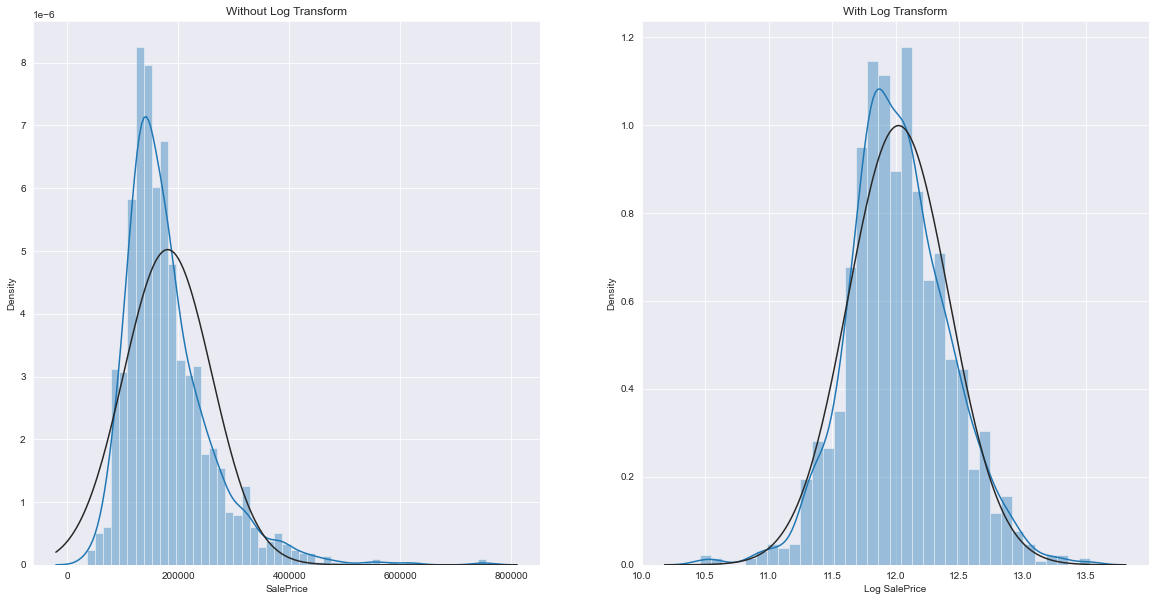

In [15]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(y_train, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(y_train+1), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [16]:
y_train = np.log(y_train + 1)

In [17]:
X_train = df.loc[:train.index.max(), :]
X_test = df.loc[train.index.max() + 1:, :].reset_index(drop=True)

In [18]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.067331,-0.227571,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.524284,0.581123,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,-0.873616,0.433500,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.571282,1.178258,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.067331,-0.095357,0.137197,0.646183,-0.507284,0.980221,0.848965,0.334237,0.098147,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,0.302568,-0.447928,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.571282,-0.494596,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.067331,0.609786,0.518903,1.355551,-0.507284,0.947203,0.753229,1.385085,0.469161,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067331,-0.359785,-0.285470,-0.063185,-0.507284,0.914184,0.753229,-0.571282,-0.968791,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1456,-0.873616,0.653857,0.381311,-0.063185,0.391237,0.220801,0.178812,0.093883,0.765532,0.670616,...,-0.032075,1.551150,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1457,0.302568,-0.183500,-0.142806,0.646183,3.086800,-1.000876,1.040437,-0.571282,-0.365071,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1458,-0.873616,-0.095357,-0.057207,-0.772552,0.391237,-0.703711,0.561757,-0.571282,-0.861219,5.790328,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [21]:
X_test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.873616,0.433500,0.184371,-0.772552,0.391237,-0.340510,-1.113625,-0.571282,0.058631,0.558290,...,-0.032075,1.551150,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,-0.873616,0.477572,0.519791,-0.063185,0.391237,-0.439565,-1.257229,0.032397,1.057514,-0.293025,...,-0.032075,1.551150,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.067331,0.169072,0.464374,-0.772552,-0.507284,0.848148,0.657493,-0.571282,0.767728,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,0.067331,0.345357,-0.024109,-0.063185,0.391237,0.881166,0.657493,-0.459489,0.352807,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
4,1.478753,-1.197142,-0.654748,1.355551,-0.507284,0.683057,0.370284,-0.571282,-0.391415,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419700,-2.166713,-1.043937,-1.481920,1.289758,-0.043346,-0.682812,-0.571282,-0.968791,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1455,2.419700,-2.166713,-1.049263,-1.481920,-0.507284,-0.043346,-0.682812,-0.571282,-0.415564,-0.293025,...,-0.032075,1.551150,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
1456,-0.873616,3.959213,1.246808,-0.772552,1.289758,-0.373528,0.561757,-0.571282,1.718313,-0.293025,...,-0.032075,-0.644683,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
1457,0.655424,-0.359785,0.034605,-0.772552,-0.507284,0.683057,0.370284,-0.571282,-0.228960,-0.293025,...,-0.032075,1.551150,0.26829,-0.147313,0.324443,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


# Model Selection

In [22]:
ctb = CatBoostRegressor(eval_metric='RMSE', iterations=6000, learning_rate=0.005, depth=4)

In [23]:
ctb.fit(X_train, y_train)

0:	learn: 0.3980550	total: 135ms	remaining: 13m 27s
1:	learn: 0.3969253	total: 137ms	remaining: 6m 51s
2:	learn: 0.3957313	total: 139ms	remaining: 4m 38s
3:	learn: 0.3944890	total: 142ms	remaining: 3m 32s
4:	learn: 0.3932429	total: 144ms	remaining: 2m 52s
5:	learn: 0.3919404	total: 147ms	remaining: 2m 26s
6:	learn: 0.3906941	total: 149ms	remaining: 2m 7s
7:	learn: 0.3895915	total: 151ms	remaining: 1m 53s
8:	learn: 0.3884429	total: 154ms	remaining: 1m 42s
9:	learn: 0.3872774	total: 156ms	remaining: 1m 33s
10:	learn: 0.3862075	total: 158ms	remaining: 1m 26s
11:	learn: 0.3850693	total: 161ms	remaining: 1m 20s
12:	learn: 0.3838649	total: 163ms	remaining: 1m 15s
13:	learn: 0.3827267	total: 166ms	remaining: 1m 10s
14:	learn: 0.3815181	total: 168ms	remaining: 1m 7s
15:	learn: 0.3804592	total: 170ms	remaining: 1m 3s
16:	learn: 0.3793345	total: 173ms	remaining: 1m
17:	learn: 0.3781335	total: 175ms	remaining: 58.2s
18:	learn: 0.3770178	total: 177ms	remaining: 55.9s
19:	learn: 0.3759205	total: 18

212:	learn: 0.2336027	total: 637ms	remaining: 17.3s
213:	learn: 0.2331718	total: 640ms	remaining: 17.3s
214:	learn: 0.2327005	total: 642ms	remaining: 17.3s
215:	learn: 0.2322839	total: 645ms	remaining: 17.3s
216:	learn: 0.2318194	total: 647ms	remaining: 17.2s
217:	learn: 0.2314027	total: 650ms	remaining: 17.2s
218:	learn: 0.2309348	total: 652ms	remaining: 17.2s
219:	learn: 0.2304862	total: 655ms	remaining: 17.2s
220:	learn: 0.2300927	total: 657ms	remaining: 17.2s
221:	learn: 0.2296720	total: 660ms	remaining: 17.2s
222:	learn: 0.2292480	total: 663ms	remaining: 17.2s
223:	learn: 0.2288120	total: 666ms	remaining: 17.2s
224:	learn: 0.2283983	total: 668ms	remaining: 17.1s
225:	learn: 0.2280364	total: 670ms	remaining: 17.1s
226:	learn: 0.2275997	total: 673ms	remaining: 17.1s
227:	learn: 0.2271565	total: 676ms	remaining: 17.1s
228:	learn: 0.2267192	total: 678ms	remaining: 17.1s
229:	learn: 0.2263014	total: 680ms	remaining: 17.1s
230:	learn: 0.2258893	total: 683ms	remaining: 17s
231:	learn: 0.

421:	learn: 0.1724618	total: 1.14s	remaining: 15.1s
422:	learn: 0.1722883	total: 1.15s	remaining: 15.1s
423:	learn: 0.1721119	total: 1.15s	remaining: 15.1s
424:	learn: 0.1719203	total: 1.15s	remaining: 15.1s
425:	learn: 0.1717366	total: 1.16s	remaining: 15.1s
426:	learn: 0.1715458	total: 1.16s	remaining: 15.1s
427:	learn: 0.1713611	total: 1.16s	remaining: 15.1s
428:	learn: 0.1712300	total: 1.16s	remaining: 15.1s
429:	learn: 0.1710409	total: 1.17s	remaining: 15.1s
430:	learn: 0.1708463	total: 1.17s	remaining: 15.1s
431:	learn: 0.1706733	total: 1.17s	remaining: 15.1s
432:	learn: 0.1704960	total: 1.18s	remaining: 15.1s
433:	learn: 0.1703140	total: 1.18s	remaining: 15.1s
434:	learn: 0.1701200	total: 1.18s	remaining: 15.1s
435:	learn: 0.1699558	total: 1.18s	remaining: 15.1s
436:	learn: 0.1697831	total: 1.19s	remaining: 15.1s
437:	learn: 0.1696556	total: 1.19s	remaining: 15.1s
438:	learn: 0.1694989	total: 1.19s	remaining: 15.1s
439:	learn: 0.1692966	total: 1.2s	remaining: 15.1s
440:	learn: 0

608:	learn: 0.1484326	total: 1.64s	remaining: 14.5s
609:	learn: 0.1483475	total: 1.64s	remaining: 14.5s
610:	learn: 0.1482610	total: 1.64s	remaining: 14.5s
611:	learn: 0.1481840	total: 1.65s	remaining: 14.5s
612:	learn: 0.1480808	total: 1.65s	remaining: 14.5s
613:	learn: 0.1480057	total: 1.65s	remaining: 14.5s
614:	learn: 0.1479121	total: 1.65s	remaining: 14.5s
615:	learn: 0.1478180	total: 1.66s	remaining: 14.5s
616:	learn: 0.1477403	total: 1.66s	remaining: 14.5s
617:	learn: 0.1476592	total: 1.66s	remaining: 14.5s
618:	learn: 0.1475662	total: 1.67s	remaining: 14.5s
619:	learn: 0.1474683	total: 1.67s	remaining: 14.5s
620:	learn: 0.1473867	total: 1.67s	remaining: 14.5s
621:	learn: 0.1472986	total: 1.67s	remaining: 14.5s
622:	learn: 0.1472149	total: 1.68s	remaining: 14.5s
623:	learn: 0.1471195	total: 1.68s	remaining: 14.5s
624:	learn: 0.1470365	total: 1.68s	remaining: 14.5s
625:	learn: 0.1469313	total: 1.68s	remaining: 14.5s
626:	learn: 0.1468413	total: 1.69s	remaining: 14.5s
627:	learn: 

814:	learn: 0.1340986	total: 2.14s	remaining: 13.6s
815:	learn: 0.1340482	total: 2.15s	remaining: 13.6s
816:	learn: 0.1339986	total: 2.15s	remaining: 13.6s
817:	learn: 0.1339547	total: 2.15s	remaining: 13.6s
818:	learn: 0.1339130	total: 2.15s	remaining: 13.6s
819:	learn: 0.1338715	total: 2.16s	remaining: 13.6s
820:	learn: 0.1338224	total: 2.16s	remaining: 13.6s
821:	learn: 0.1337527	total: 2.16s	remaining: 13.6s
822:	learn: 0.1336827	total: 2.17s	remaining: 13.6s
823:	learn: 0.1336117	total: 2.17s	remaining: 13.6s
824:	learn: 0.1335681	total: 2.17s	remaining: 13.6s
825:	learn: 0.1335195	total: 2.17s	remaining: 13.6s
826:	learn: 0.1334623	total: 2.18s	remaining: 13.6s
827:	learn: 0.1334192	total: 2.18s	remaining: 13.6s
828:	learn: 0.1333691	total: 2.18s	remaining: 13.6s
829:	learn: 0.1333144	total: 2.19s	remaining: 13.6s
830:	learn: 0.1332525	total: 2.19s	remaining: 13.6s
831:	learn: 0.1332051	total: 2.19s	remaining: 13.6s
832:	learn: 0.1331544	total: 2.19s	remaining: 13.6s
833:	learn: 

1002:	learn: 0.1254612	total: 2.64s	remaining: 13.2s
1003:	learn: 0.1254359	total: 2.64s	remaining: 13.2s
1004:	learn: 0.1254042	total: 2.65s	remaining: 13.2s
1005:	learn: 0.1253695	total: 2.65s	remaining: 13.1s
1006:	learn: 0.1253192	total: 2.65s	remaining: 13.1s
1007:	learn: 0.1252762	total: 2.65s	remaining: 13.1s
1008:	learn: 0.1252461	total: 2.66s	remaining: 13.1s
1009:	learn: 0.1252099	total: 2.66s	remaining: 13.1s
1010:	learn: 0.1251783	total: 2.66s	remaining: 13.1s
1011:	learn: 0.1251421	total: 2.67s	remaining: 13.1s
1012:	learn: 0.1250966	total: 2.67s	remaining: 13.1s
1013:	learn: 0.1250497	total: 2.67s	remaining: 13.1s
1014:	learn: 0.1250163	total: 2.67s	remaining: 13.1s
1015:	learn: 0.1249880	total: 2.68s	remaining: 13.1s
1016:	learn: 0.1249468	total: 2.68s	remaining: 13.1s
1017:	learn: 0.1249002	total: 2.68s	remaining: 13.1s
1018:	learn: 0.1248699	total: 2.68s	remaining: 13.1s
1019:	learn: 0.1248279	total: 2.69s	remaining: 13.1s
1020:	learn: 0.1247820	total: 2.69s	remaining:

1194:	learn: 0.1189906	total: 3.13s	remaining: 12.6s
1195:	learn: 0.1189492	total: 3.14s	remaining: 12.6s
1196:	learn: 0.1189126	total: 3.14s	remaining: 12.6s
1197:	learn: 0.1188891	total: 3.14s	remaining: 12.6s
1198:	learn: 0.1188613	total: 3.14s	remaining: 12.6s
1199:	learn: 0.1188253	total: 3.15s	remaining: 12.6s
1200:	learn: 0.1187942	total: 3.15s	remaining: 12.6s
1201:	learn: 0.1187764	total: 3.15s	remaining: 12.6s
1202:	learn: 0.1187605	total: 3.16s	remaining: 12.6s
1203:	learn: 0.1187292	total: 3.16s	remaining: 12.6s
1204:	learn: 0.1186910	total: 3.16s	remaining: 12.6s
1205:	learn: 0.1186647	total: 3.16s	remaining: 12.6s
1206:	learn: 0.1186506	total: 3.17s	remaining: 12.6s
1207:	learn: 0.1186303	total: 3.17s	remaining: 12.6s
1208:	learn: 0.1186051	total: 3.17s	remaining: 12.6s
1209:	learn: 0.1185841	total: 3.17s	remaining: 12.6s
1210:	learn: 0.1185379	total: 3.18s	remaining: 12.6s
1211:	learn: 0.1185034	total: 3.18s	remaining: 12.6s
1212:	learn: 0.1184937	total: 3.18s	remaining:

1397:	learn: 0.1138946	total: 3.63s	remaining: 12s
1398:	learn: 0.1138592	total: 3.64s	remaining: 12s
1399:	learn: 0.1138361	total: 3.64s	remaining: 12s
1400:	learn: 0.1138256	total: 3.64s	remaining: 12s
1401:	learn: 0.1137933	total: 3.65s	remaining: 12s
1402:	learn: 0.1137733	total: 3.65s	remaining: 12s
1403:	learn: 0.1137554	total: 3.65s	remaining: 12s
1404:	learn: 0.1137363	total: 3.66s	remaining: 12s
1405:	learn: 0.1137171	total: 3.66s	remaining: 12s
1406:	learn: 0.1136984	total: 3.66s	remaining: 12s
1407:	learn: 0.1136619	total: 3.67s	remaining: 12s
1408:	learn: 0.1136519	total: 3.67s	remaining: 12s
1409:	learn: 0.1136381	total: 3.67s	remaining: 12s
1410:	learn: 0.1136210	total: 3.67s	remaining: 11.9s
1411:	learn: 0.1136003	total: 3.68s	remaining: 11.9s
1412:	learn: 0.1135795	total: 3.68s	remaining: 11.9s
1413:	learn: 0.1135622	total: 3.68s	remaining: 11.9s
1414:	learn: 0.1135451	total: 3.69s	remaining: 11.9s
1415:	learn: 0.1135200	total: 3.69s	remaining: 11.9s
1416:	learn: 0.1134

1600:	learn: 0.1097906	total: 4.13s	remaining: 11.4s
1601:	learn: 0.1097691	total: 4.14s	remaining: 11.4s
1602:	learn: 0.1097408	total: 4.14s	remaining: 11.4s
1603:	learn: 0.1097192	total: 4.14s	remaining: 11.4s
1604:	learn: 0.1096973	total: 4.14s	remaining: 11.3s
1605:	learn: 0.1096805	total: 4.15s	remaining: 11.3s
1606:	learn: 0.1096539	total: 4.15s	remaining: 11.3s
1607:	learn: 0.1096427	total: 4.15s	remaining: 11.3s
1608:	learn: 0.1096300	total: 4.16s	remaining: 11.3s
1609:	learn: 0.1096165	total: 4.16s	remaining: 11.3s
1610:	learn: 0.1095976	total: 4.16s	remaining: 11.3s
1611:	learn: 0.1095803	total: 4.17s	remaining: 11.3s
1612:	learn: 0.1095528	total: 4.17s	remaining: 11.3s
1613:	learn: 0.1095440	total: 4.17s	remaining: 11.3s
1614:	learn: 0.1095193	total: 4.17s	remaining: 11.3s
1615:	learn: 0.1094935	total: 4.18s	remaining: 11.3s
1616:	learn: 0.1094828	total: 4.18s	remaining: 11.3s
1617:	learn: 0.1094719	total: 4.18s	remaining: 11.3s
1618:	learn: 0.1094604	total: 4.18s	remaining:

1805:	learn: 0.1061559	total: 4.64s	remaining: 10.8s
1806:	learn: 0.1061324	total: 4.64s	remaining: 10.8s
1807:	learn: 0.1061156	total: 4.64s	remaining: 10.8s
1808:	learn: 0.1061076	total: 4.64s	remaining: 10.8s
1809:	learn: 0.1060940	total: 4.65s	remaining: 10.8s
1810:	learn: 0.1060783	total: 4.65s	remaining: 10.8s
1811:	learn: 0.1060640	total: 4.65s	remaining: 10.8s
1812:	learn: 0.1060473	total: 4.66s	remaining: 10.8s
1813:	learn: 0.1060314	total: 4.67s	remaining: 10.8s
1814:	learn: 0.1060125	total: 4.67s	remaining: 10.8s
1815:	learn: 0.1059943	total: 4.68s	remaining: 10.8s
1816:	learn: 0.1059794	total: 4.68s	remaining: 10.8s
1817:	learn: 0.1059644	total: 4.69s	remaining: 10.8s
1818:	learn: 0.1059445	total: 4.69s	remaining: 10.8s
1819:	learn: 0.1059284	total: 4.69s	remaining: 10.8s
1820:	learn: 0.1059038	total: 4.7s	remaining: 10.8s
1821:	learn: 0.1058901	total: 4.7s	remaining: 10.8s
1822:	learn: 0.1058666	total: 4.7s	remaining: 10.8s
1823:	learn: 0.1058449	total: 4.7s	remaining: 10.

2005:	learn: 0.1033166	total: 5.14s	remaining: 10.2s
2006:	learn: 0.1032939	total: 5.14s	remaining: 10.2s
2007:	learn: 0.1032754	total: 5.15s	remaining: 10.2s
2008:	learn: 0.1032543	total: 5.15s	remaining: 10.2s
2009:	learn: 0.1032327	total: 5.15s	remaining: 10.2s
2010:	learn: 0.1032260	total: 5.16s	remaining: 10.2s
2011:	learn: 0.1032188	total: 5.16s	remaining: 10.2s
2012:	learn: 0.1032048	total: 5.16s	remaining: 10.2s
2013:	learn: 0.1032000	total: 5.16s	remaining: 10.2s
2014:	learn: 0.1031799	total: 5.17s	remaining: 10.2s
2015:	learn: 0.1031679	total: 5.17s	remaining: 10.2s
2016:	learn: 0.1031466	total: 5.17s	remaining: 10.2s
2017:	learn: 0.1031313	total: 5.17s	remaining: 10.2s
2018:	learn: 0.1031275	total: 5.18s	remaining: 10.2s
2019:	learn: 0.1031130	total: 5.18s	remaining: 10.2s
2020:	learn: 0.1031012	total: 5.18s	remaining: 10.2s
2021:	learn: 0.1030948	total: 5.18s	remaining: 10.2s
2022:	learn: 0.1030868	total: 5.19s	remaining: 10.2s
2023:	learn: 0.1030738	total: 5.19s	remaining:

2208:	learn: 0.1006153	total: 5.64s	remaining: 9.68s
2209:	learn: 0.1006120	total: 5.64s	remaining: 9.68s
2210:	learn: 0.1005916	total: 5.65s	remaining: 9.68s
2211:	learn: 0.1005893	total: 5.65s	remaining: 9.68s
2212:	learn: 0.1005778	total: 5.65s	remaining: 9.67s
2213:	learn: 0.1005697	total: 5.66s	remaining: 9.67s
2214:	learn: 0.1005495	total: 5.66s	remaining: 9.67s
2215:	learn: 0.1005388	total: 5.66s	remaining: 9.67s
2216:	learn: 0.1005228	total: 5.66s	remaining: 9.67s
2217:	learn: 0.1005077	total: 5.67s	remaining: 9.66s
2218:	learn: 0.1004895	total: 5.67s	remaining: 9.66s
2219:	learn: 0.1004693	total: 5.67s	remaining: 9.66s
2220:	learn: 0.1004584	total: 5.67s	remaining: 9.65s
2221:	learn: 0.1004463	total: 5.68s	remaining: 9.65s
2222:	learn: 0.1004278	total: 5.68s	remaining: 9.65s
2223:	learn: 0.1004089	total: 5.68s	remaining: 9.65s
2224:	learn: 0.1003968	total: 5.68s	remaining: 9.64s
2225:	learn: 0.1003941	total: 5.69s	remaining: 9.64s
2226:	learn: 0.1003754	total: 5.69s	remaining:

2415:	learn: 0.0981968	total: 6.15s	remaining: 9.12s
2416:	learn: 0.0981926	total: 6.15s	remaining: 9.12s
2417:	learn: 0.0981832	total: 6.15s	remaining: 9.11s
2418:	learn: 0.0981662	total: 6.15s	remaining: 9.11s
2419:	learn: 0.0981622	total: 6.16s	remaining: 9.11s
2420:	learn: 0.0981436	total: 6.16s	remaining: 9.11s
2421:	learn: 0.0981338	total: 6.16s	remaining: 9.1s
2422:	learn: 0.0981192	total: 6.16s	remaining: 9.1s
2423:	learn: 0.0981048	total: 6.17s	remaining: 9.1s
2424:	learn: 0.0981007	total: 6.17s	remaining: 9.1s
2425:	learn: 0.0980975	total: 6.17s	remaining: 9.09s
2426:	learn: 0.0980802	total: 6.17s	remaining: 9.09s
2427:	learn: 0.0980770	total: 6.18s	remaining: 9.09s
2428:	learn: 0.0980728	total: 6.18s	remaining: 9.09s
2429:	learn: 0.0980708	total: 6.18s	remaining: 9.08s
2430:	learn: 0.0980618	total: 6.18s	remaining: 9.08s
2431:	learn: 0.0980519	total: 6.19s	remaining: 9.08s
2432:	learn: 0.0980424	total: 6.19s	remaining: 9.08s
2433:	learn: 0.0980249	total: 6.19s	remaining: 9.0

2618:	learn: 0.0960589	total: 6.65s	remaining: 8.58s
2619:	learn: 0.0960449	total: 6.65s	remaining: 8.58s
2620:	learn: 0.0960339	total: 6.65s	remaining: 8.58s
2621:	learn: 0.0960252	total: 6.66s	remaining: 8.57s
2622:	learn: 0.0960160	total: 6.66s	remaining: 8.57s
2623:	learn: 0.0960007	total: 6.66s	remaining: 8.57s
2624:	learn: 0.0959913	total: 6.66s	remaining: 8.57s
2625:	learn: 0.0959853	total: 6.67s	remaining: 8.57s
2626:	learn: 0.0959834	total: 6.67s	remaining: 8.56s
2627:	learn: 0.0959802	total: 6.67s	remaining: 8.56s
2628:	learn: 0.0959734	total: 6.68s	remaining: 8.56s
2629:	learn: 0.0959642	total: 6.68s	remaining: 8.56s
2630:	learn: 0.0959529	total: 6.68s	remaining: 8.55s
2631:	learn: 0.0959379	total: 6.68s	remaining: 8.55s
2632:	learn: 0.0959244	total: 6.69s	remaining: 8.55s
2633:	learn: 0.0959141	total: 6.69s	remaining: 8.55s
2634:	learn: 0.0958985	total: 6.69s	remaining: 8.54s
2635:	learn: 0.0958877	total: 6.69s	remaining: 8.54s
2636:	learn: 0.0958718	total: 6.7s	remaining: 

2822:	learn: 0.0940437	total: 7.15s	remaining: 8.05s
2823:	learn: 0.0940282	total: 7.15s	remaining: 8.04s
2824:	learn: 0.0940143	total: 7.16s	remaining: 8.04s
2825:	learn: 0.0940035	total: 7.16s	remaining: 8.04s
2826:	learn: 0.0939893	total: 7.16s	remaining: 8.04s
2827:	learn: 0.0939755	total: 7.16s	remaining: 8.04s
2828:	learn: 0.0939654	total: 7.17s	remaining: 8.03s
2829:	learn: 0.0939580	total: 7.17s	remaining: 8.03s
2830:	learn: 0.0939520	total: 7.17s	remaining: 8.03s
2831:	learn: 0.0939412	total: 7.18s	remaining: 8.03s
2832:	learn: 0.0939280	total: 7.18s	remaining: 8.03s
2833:	learn: 0.0939256	total: 7.18s	remaining: 8.02s
2834:	learn: 0.0939134	total: 7.18s	remaining: 8.02s
2835:	learn: 0.0938886	total: 7.19s	remaining: 8.02s
2836:	learn: 0.0938783	total: 7.19s	remaining: 8.02s
2837:	learn: 0.0938649	total: 7.19s	remaining: 8.01s
2838:	learn: 0.0938573	total: 7.2s	remaining: 8.01s
2839:	learn: 0.0938458	total: 7.2s	remaining: 8.01s
2840:	learn: 0.0938345	total: 7.2s	remaining: 8.

3026:	learn: 0.0920114	total: 7.65s	remaining: 7.52s
3027:	learn: 0.0919963	total: 7.66s	remaining: 7.51s
3028:	learn: 0.0919822	total: 7.66s	remaining: 7.51s
3029:	learn: 0.0919774	total: 7.66s	remaining: 7.51s
3030:	learn: 0.0919657	total: 7.67s	remaining: 7.51s
3031:	learn: 0.0919586	total: 7.67s	remaining: 7.51s
3032:	learn: 0.0919349	total: 7.67s	remaining: 7.5s
3033:	learn: 0.0919212	total: 7.67s	remaining: 7.5s
3034:	learn: 0.0919083	total: 7.68s	remaining: 7.5s
3035:	learn: 0.0919020	total: 7.68s	remaining: 7.5s
3036:	learn: 0.0918927	total: 7.68s	remaining: 7.5s
3037:	learn: 0.0918869	total: 7.69s	remaining: 7.49s
3038:	learn: 0.0918772	total: 7.69s	remaining: 7.49s
3039:	learn: 0.0918674	total: 7.69s	remaining: 7.49s
3040:	learn: 0.0918610	total: 7.69s	remaining: 7.49s
3041:	learn: 0.0918511	total: 7.7s	remaining: 7.48s
3042:	learn: 0.0918419	total: 7.7s	remaining: 7.48s
3043:	learn: 0.0918362	total: 7.7s	remaining: 7.48s
3044:	learn: 0.0918308	total: 7.7s	remaining: 7.48s
30

3214:	learn: 0.0904883	total: 8.15s	remaining: 7.06s
3215:	learn: 0.0904774	total: 8.16s	remaining: 7.06s
3216:	learn: 0.0904713	total: 8.16s	remaining: 7.06s
3217:	learn: 0.0904615	total: 8.16s	remaining: 7.06s
3218:	learn: 0.0904544	total: 8.17s	remaining: 7.05s
3219:	learn: 0.0904451	total: 8.17s	remaining: 7.05s
3220:	learn: 0.0904328	total: 8.17s	remaining: 7.05s
3221:	learn: 0.0904080	total: 8.18s	remaining: 7.05s
3222:	learn: 0.0904065	total: 8.18s	remaining: 7.05s
3223:	learn: 0.0903952	total: 8.18s	remaining: 7.04s
3224:	learn: 0.0903849	total: 8.19s	remaining: 7.04s
3225:	learn: 0.0903783	total: 8.19s	remaining: 7.04s
3226:	learn: 0.0903767	total: 8.19s	remaining: 7.04s
3227:	learn: 0.0903649	total: 8.19s	remaining: 7.04s
3228:	learn: 0.0903527	total: 8.2s	remaining: 7.03s
3229:	learn: 0.0903402	total: 8.2s	remaining: 7.03s
3230:	learn: 0.0903354	total: 8.2s	remaining: 7.03s
3231:	learn: 0.0903284	total: 8.21s	remaining: 7.03s
3232:	learn: 0.0903267	total: 8.21s	remaining: 7.

3389:	learn: 0.0890961	total: 8.65s	remaining: 6.66s
3390:	learn: 0.0890874	total: 8.65s	remaining: 6.66s
3391:	learn: 0.0890784	total: 8.66s	remaining: 6.66s
3392:	learn: 0.0890675	total: 8.66s	remaining: 6.66s
3393:	learn: 0.0890646	total: 8.66s	remaining: 6.65s
3394:	learn: 0.0890541	total: 8.67s	remaining: 6.65s
3395:	learn: 0.0890507	total: 8.67s	remaining: 6.65s
3396:	learn: 0.0890418	total: 8.68s	remaining: 6.65s
3397:	learn: 0.0890329	total: 8.68s	remaining: 6.64s
3398:	learn: 0.0890206	total: 8.68s	remaining: 6.64s
3399:	learn: 0.0890190	total: 8.69s	remaining: 6.64s
3400:	learn: 0.0890091	total: 8.69s	remaining: 6.64s
3401:	learn: 0.0889929	total: 8.69s	remaining: 6.64s
3402:	learn: 0.0889822	total: 8.69s	remaining: 6.63s
3403:	learn: 0.0889702	total: 8.7s	remaining: 6.63s
3404:	learn: 0.0889646	total: 8.7s	remaining: 6.63s
3405:	learn: 0.0889580	total: 8.7s	remaining: 6.63s
3406:	learn: 0.0889490	total: 8.71s	remaining: 6.63s
3407:	learn: 0.0889477	total: 8.71s	remaining: 6.

3566:	learn: 0.0877625	total: 9.15s	remaining: 6.24s
3567:	learn: 0.0877613	total: 9.16s	remaining: 6.24s
3568:	learn: 0.0877548	total: 9.16s	remaining: 6.24s
3569:	learn: 0.0877442	total: 9.16s	remaining: 6.24s
3570:	learn: 0.0877307	total: 9.17s	remaining: 6.23s
3571:	learn: 0.0877202	total: 9.17s	remaining: 6.23s
3572:	learn: 0.0877097	total: 9.17s	remaining: 6.23s
3573:	learn: 0.0877036	total: 9.18s	remaining: 6.23s
3574:	learn: 0.0876971	total: 9.18s	remaining: 6.23s
3575:	learn: 0.0876896	total: 9.18s	remaining: 6.22s
3576:	learn: 0.0876884	total: 9.19s	remaining: 6.22s
3577:	learn: 0.0876835	total: 9.19s	remaining: 6.22s
3578:	learn: 0.0876746	total: 9.19s	remaining: 6.22s
3579:	learn: 0.0876734	total: 9.19s	remaining: 6.21s
3580:	learn: 0.0876626	total: 9.2s	remaining: 6.21s
3581:	learn: 0.0876613	total: 9.2s	remaining: 6.21s
3582:	learn: 0.0876548	total: 9.2s	remaining: 6.21s
3583:	learn: 0.0876536	total: 9.21s	remaining: 6.21s
3584:	learn: 0.0876477	total: 9.21s	remaining: 6.

3753:	learn: 0.0863193	total: 9.65s	remaining: 5.77s
3754:	learn: 0.0863179	total: 9.65s	remaining: 5.77s
3755:	learn: 0.0863168	total: 9.66s	remaining: 5.77s
3756:	learn: 0.0863024	total: 9.66s	remaining: 5.77s
3757:	learn: 0.0862942	total: 9.66s	remaining: 5.76s
3758:	learn: 0.0862878	total: 9.67s	remaining: 5.76s
3759:	learn: 0.0862820	total: 9.67s	remaining: 5.76s
3760:	learn: 0.0862756	total: 9.67s	remaining: 5.76s
3761:	learn: 0.0862648	total: 9.68s	remaining: 5.76s
3762:	learn: 0.0862569	total: 9.68s	remaining: 5.75s
3763:	learn: 0.0862482	total: 9.68s	remaining: 5.75s
3764:	learn: 0.0862416	total: 9.68s	remaining: 5.75s
3765:	learn: 0.0862328	total: 9.69s	remaining: 5.75s
3766:	learn: 0.0862317	total: 9.69s	remaining: 5.74s
3767:	learn: 0.0862277	total: 9.69s	remaining: 5.74s
3768:	learn: 0.0862173	total: 9.7s	remaining: 5.74s
3769:	learn: 0.0862081	total: 9.7s	remaining: 5.74s
3770:	learn: 0.0861993	total: 9.7s	remaining: 5.73s
3771:	learn: 0.0861918	total: 9.7s	remaining: 5.7

3949:	learn: 0.0849212	total: 10.2s	remaining: 5.27s
3950:	learn: 0.0849199	total: 10.2s	remaining: 5.27s
3951:	learn: 0.0849135	total: 10.2s	remaining: 5.27s
3952:	learn: 0.0849066	total: 10.2s	remaining: 5.26s
3953:	learn: 0.0849008	total: 10.2s	remaining: 5.26s
3954:	learn: 0.0848961	total: 10.2s	remaining: 5.26s
3955:	learn: 0.0848951	total: 10.2s	remaining: 5.25s
3956:	learn: 0.0848900	total: 10.2s	remaining: 5.25s
3957:	learn: 0.0848805	total: 10.2s	remaining: 5.25s
3958:	learn: 0.0848738	total: 10.2s	remaining: 5.25s
3959:	learn: 0.0848687	total: 10.2s	remaining: 5.25s
3960:	learn: 0.0848635	total: 10.2s	remaining: 5.24s
3961:	learn: 0.0848548	total: 10.2s	remaining: 5.24s
3962:	learn: 0.0848535	total: 10.2s	remaining: 5.24s
3963:	learn: 0.0848522	total: 10.2s	remaining: 5.24s
3964:	learn: 0.0848458	total: 10.2s	remaining: 5.23s
3965:	learn: 0.0848383	total: 10.2s	remaining: 5.23s
3966:	learn: 0.0848301	total: 10.2s	remaining: 5.23s
3967:	learn: 0.0848165	total: 10.2s	remaining:

4151:	learn: 0.0836116	total: 10.7s	remaining: 4.75s
4152:	learn: 0.0836034	total: 10.7s	remaining: 4.74s
4153:	learn: 0.0835938	total: 10.7s	remaining: 4.74s
4154:	learn: 0.0835846	total: 10.7s	remaining: 4.74s
4155:	learn: 0.0835740	total: 10.7s	remaining: 4.74s
4156:	learn: 0.0835667	total: 10.7s	remaining: 4.73s
4157:	learn: 0.0835599	total: 10.7s	remaining: 4.73s
4158:	learn: 0.0835561	total: 10.7s	remaining: 4.73s
4159:	learn: 0.0835473	total: 10.7s	remaining: 4.72s
4160:	learn: 0.0835462	total: 10.7s	remaining: 4.72s
4161:	learn: 0.0835415	total: 10.7s	remaining: 4.72s
4162:	learn: 0.0835342	total: 10.7s	remaining: 4.72s
4163:	learn: 0.0835267	total: 10.7s	remaining: 4.72s
4164:	learn: 0.0835158	total: 10.7s	remaining: 4.71s
4165:	learn: 0.0835108	total: 10.7s	remaining: 4.71s
4166:	learn: 0.0835035	total: 10.7s	remaining: 4.71s
4167:	learn: 0.0834957	total: 10.7s	remaining: 4.71s
4168:	learn: 0.0834909	total: 10.7s	remaining: 4.71s
4169:	learn: 0.0834877	total: 10.7s	remaining:

4347:	learn: 0.0822603	total: 11.2s	remaining: 4.24s
4348:	learn: 0.0822552	total: 11.2s	remaining: 4.24s
4349:	learn: 0.0822452	total: 11.2s	remaining: 4.24s
4350:	learn: 0.0822375	total: 11.2s	remaining: 4.24s
4351:	learn: 0.0822331	total: 11.2s	remaining: 4.23s
4352:	learn: 0.0822287	total: 11.2s	remaining: 4.23s
4353:	learn: 0.0822256	total: 11.2s	remaining: 4.23s
4354:	learn: 0.0822216	total: 11.2s	remaining: 4.22s
4355:	learn: 0.0822167	total: 11.2s	remaining: 4.22s
4356:	learn: 0.0822105	total: 11.2s	remaining: 4.22s
4357:	learn: 0.0822092	total: 11.2s	remaining: 4.22s
4358:	learn: 0.0821953	total: 11.2s	remaining: 4.21s
4359:	learn: 0.0821877	total: 11.2s	remaining: 4.21s
4360:	learn: 0.0821783	total: 11.2s	remaining: 4.21s
4361:	learn: 0.0821659	total: 11.2s	remaining: 4.21s
4362:	learn: 0.0821620	total: 11.2s	remaining: 4.2s
4363:	learn: 0.0821591	total: 11.2s	remaining: 4.2s
4364:	learn: 0.0821518	total: 11.2s	remaining: 4.2s
4365:	learn: 0.0821454	total: 11.2s	remaining: 4.

4546:	learn: 0.0808912	total: 11.7s	remaining: 3.73s
4547:	learn: 0.0808871	total: 11.7s	remaining: 3.73s
4548:	learn: 0.0808859	total: 11.7s	remaining: 3.72s
4549:	learn: 0.0808760	total: 11.7s	remaining: 3.72s
4550:	learn: 0.0808721	total: 11.7s	remaining: 3.72s
4551:	learn: 0.0808659	total: 11.7s	remaining: 3.72s
4552:	learn: 0.0808570	total: 11.7s	remaining: 3.71s
4553:	learn: 0.0808509	total: 11.7s	remaining: 3.71s
4554:	learn: 0.0808500	total: 11.7s	remaining: 3.71s
4555:	learn: 0.0808464	total: 11.7s	remaining: 3.71s
4556:	learn: 0.0808456	total: 11.7s	remaining: 3.7s
4557:	learn: 0.0808381	total: 11.7s	remaining: 3.7s
4558:	learn: 0.0808318	total: 11.7s	remaining: 3.7s
4559:	learn: 0.0808269	total: 11.7s	remaining: 3.7s
4560:	learn: 0.0808208	total: 11.7s	remaining: 3.69s
4561:	learn: 0.0808138	total: 11.7s	remaining: 3.69s
4562:	learn: 0.0808071	total: 11.7s	remaining: 3.69s
4563:	learn: 0.0808028	total: 11.7s	remaining: 3.69s
4564:	learn: 0.0807943	total: 11.7s	remaining: 3.6

4746:	learn: 0.0796289	total: 12.2s	remaining: 3.21s
4747:	learn: 0.0796245	total: 12.2s	remaining: 3.21s
4748:	learn: 0.0796209	total: 12.2s	remaining: 3.21s
4749:	learn: 0.0796157	total: 12.2s	remaining: 3.21s
4750:	learn: 0.0796147	total: 12.2s	remaining: 3.2s
4751:	learn: 0.0796058	total: 12.2s	remaining: 3.2s
4752:	learn: 0.0795987	total: 12.2s	remaining: 3.2s
4753:	learn: 0.0795925	total: 12.2s	remaining: 3.2s
4754:	learn: 0.0795862	total: 12.2s	remaining: 3.19s
4755:	learn: 0.0795765	total: 12.2s	remaining: 3.19s
4756:	learn: 0.0795728	total: 12.2s	remaining: 3.19s
4757:	learn: 0.0795615	total: 12.2s	remaining: 3.19s
4758:	learn: 0.0795606	total: 12.2s	remaining: 3.18s
4759:	learn: 0.0795567	total: 12.2s	remaining: 3.18s
4760:	learn: 0.0795505	total: 12.2s	remaining: 3.18s
4761:	learn: 0.0795446	total: 12.2s	remaining: 3.18s
4762:	learn: 0.0795374	total: 12.2s	remaining: 3.17s
4763:	learn: 0.0795302	total: 12.2s	remaining: 3.17s
4764:	learn: 0.0795213	total: 12.2s	remaining: 3.1

4942:	learn: 0.0783858	total: 12.7s	remaining: 2.71s
4943:	learn: 0.0783798	total: 12.7s	remaining: 2.71s
4944:	learn: 0.0783734	total: 12.7s	remaining: 2.71s
4945:	learn: 0.0783645	total: 12.7s	remaining: 2.7s
4946:	learn: 0.0783635	total: 12.7s	remaining: 2.7s
4947:	learn: 0.0783560	total: 12.7s	remaining: 2.7s
4948:	learn: 0.0783498	total: 12.7s	remaining: 2.69s
4949:	learn: 0.0783418	total: 12.7s	remaining: 2.69s
4950:	learn: 0.0783326	total: 12.7s	remaining: 2.69s
4951:	learn: 0.0783275	total: 12.7s	remaining: 2.69s
4952:	learn: 0.0783186	total: 12.7s	remaining: 2.69s
4953:	learn: 0.0783046	total: 12.7s	remaining: 2.68s
4954:	learn: 0.0783033	total: 12.7s	remaining: 2.68s
4955:	learn: 0.0782988	total: 12.7s	remaining: 2.68s
4956:	learn: 0.0782890	total: 12.7s	remaining: 2.67s
4957:	learn: 0.0782813	total: 12.7s	remaining: 2.67s
4958:	learn: 0.0782746	total: 12.7s	remaining: 2.67s
4959:	learn: 0.0782689	total: 12.7s	remaining: 2.67s
4960:	learn: 0.0782621	total: 12.7s	remaining: 2.

5138:	learn: 0.0772344	total: 13.2s	remaining: 2.21s
5139:	learn: 0.0772310	total: 13.2s	remaining: 2.21s
5140:	learn: 0.0772230	total: 13.2s	remaining: 2.2s
5141:	learn: 0.0772217	total: 13.2s	remaining: 2.2s
5142:	learn: 0.0772168	total: 13.2s	remaining: 2.2s
5143:	learn: 0.0772117	total: 13.2s	remaining: 2.19s
5144:	learn: 0.0772054	total: 13.2s	remaining: 2.19s
5145:	learn: 0.0771986	total: 13.2s	remaining: 2.19s
5146:	learn: 0.0771978	total: 13.2s	remaining: 2.19s
5147:	learn: 0.0771968	total: 13.2s	remaining: 2.19s
5148:	learn: 0.0771879	total: 13.2s	remaining: 2.18s
5149:	learn: 0.0771820	total: 13.2s	remaining: 2.18s
5150:	learn: 0.0771811	total: 13.2s	remaining: 2.18s
5151:	learn: 0.0771759	total: 13.2s	remaining: 2.17s
5152:	learn: 0.0771721	total: 13.2s	remaining: 2.17s
5153:	learn: 0.0771665	total: 13.2s	remaining: 2.17s
5154:	learn: 0.0771627	total: 13.2s	remaining: 2.17s
5155:	learn: 0.0771549	total: 13.2s	remaining: 2.16s
5156:	learn: 0.0771490	total: 13.2s	remaining: 2.

5337:	learn: 0.0761767	total: 13.7s	remaining: 1.7s
5338:	learn: 0.0761708	total: 13.7s	remaining: 1.69s
5339:	learn: 0.0761605	total: 13.7s	remaining: 1.69s
5340:	learn: 0.0761523	total: 13.7s	remaining: 1.69s
5341:	learn: 0.0761492	total: 13.7s	remaining: 1.69s
5342:	learn: 0.0761419	total: 13.7s	remaining: 1.68s
5343:	learn: 0.0761411	total: 13.7s	remaining: 1.68s
5344:	learn: 0.0761350	total: 13.7s	remaining: 1.68s
5345:	learn: 0.0761256	total: 13.7s	remaining: 1.68s
5346:	learn: 0.0761249	total: 13.7s	remaining: 1.67s
5347:	learn: 0.0761186	total: 13.7s	remaining: 1.67s
5348:	learn: 0.0761179	total: 13.7s	remaining: 1.67s
5349:	learn: 0.0761118	total: 13.7s	remaining: 1.67s
5350:	learn: 0.0761045	total: 13.7s	remaining: 1.66s
5351:	learn: 0.0760981	total: 13.7s	remaining: 1.66s
5352:	learn: 0.0760924	total: 13.7s	remaining: 1.66s
5353:	learn: 0.0760889	total: 13.7s	remaining: 1.66s
5354:	learn: 0.0760837	total: 13.7s	remaining: 1.65s
5355:	learn: 0.0760788	total: 13.7s	remaining: 

5529:	learn: 0.0753677	total: 14.2s	remaining: 1.21s
5530:	learn: 0.0753653	total: 14.2s	remaining: 1.2s
5531:	learn: 0.0753647	total: 14.2s	remaining: 1.2s
5532:	learn: 0.0753611	total: 14.2s	remaining: 1.2s
5533:	learn: 0.0753603	total: 14.2s	remaining: 1.2s
5534:	learn: 0.0753575	total: 14.2s	remaining: 1.19s
5535:	learn: 0.0753532	total: 14.2s	remaining: 1.19s
5536:	learn: 0.0753468	total: 14.2s	remaining: 1.19s
5537:	learn: 0.0753462	total: 14.2s	remaining: 1.19s
5538:	learn: 0.0753399	total: 14.2s	remaining: 1.18s
5539:	learn: 0.0753319	total: 14.2s	remaining: 1.18s
5540:	learn: 0.0753313	total: 14.2s	remaining: 1.18s
5541:	learn: 0.0753306	total: 14.2s	remaining: 1.18s
5542:	learn: 0.0753287	total: 14.2s	remaining: 1.17s
5543:	learn: 0.0753209	total: 14.2s	remaining: 1.17s
5544:	learn: 0.0753132	total: 14.2s	remaining: 1.17s
5545:	learn: 0.0753054	total: 14.2s	remaining: 1.16s
5546:	learn: 0.0753048	total: 14.2s	remaining: 1.16s
5547:	learn: 0.0752983	total: 14.2s	remaining: 1.1

5727:	learn: 0.0745419	total: 14.7s	remaining: 697ms
5728:	learn: 0.0745348	total: 14.7s	remaining: 695ms
5729:	learn: 0.0745288	total: 14.7s	remaining: 692ms
5730:	learn: 0.0745192	total: 14.7s	remaining: 690ms
5731:	learn: 0.0745186	total: 14.7s	remaining: 687ms
5732:	learn: 0.0745167	total: 14.7s	remaining: 685ms
5733:	learn: 0.0745111	total: 14.7s	remaining: 682ms
5734:	learn: 0.0745077	total: 14.7s	remaining: 680ms
5735:	learn: 0.0744997	total: 14.7s	remaining: 677ms
5736:	learn: 0.0744991	total: 14.7s	remaining: 674ms
5737:	learn: 0.0744958	total: 14.7s	remaining: 672ms
5738:	learn: 0.0744901	total: 14.7s	remaining: 669ms
5739:	learn: 0.0744895	total: 14.7s	remaining: 667ms
5740:	learn: 0.0744832	total: 14.7s	remaining: 664ms
5741:	learn: 0.0744764	total: 14.7s	remaining: 662ms
5742:	learn: 0.0744758	total: 14.7s	remaining: 659ms
5743:	learn: 0.0744651	total: 14.7s	remaining: 657ms
5744:	learn: 0.0744535	total: 14.7s	remaining: 654ms
5745:	learn: 0.0744447	total: 14.7s	remaining:

5925:	learn: 0.0735407	total: 15.2s	remaining: 190ms
5926:	learn: 0.0735373	total: 15.2s	remaining: 187ms
5927:	learn: 0.0735342	total: 15.2s	remaining: 185ms
5928:	learn: 0.0735271	total: 15.2s	remaining: 182ms
5929:	learn: 0.0735266	total: 15.2s	remaining: 179ms
5930:	learn: 0.0735205	total: 15.2s	remaining: 177ms
5931:	learn: 0.0735200	total: 15.2s	remaining: 174ms
5932:	learn: 0.0735115	total: 15.2s	remaining: 172ms
5933:	learn: 0.0735099	total: 15.2s	remaining: 169ms
5934:	learn: 0.0735026	total: 15.2s	remaining: 167ms
5935:	learn: 0.0734990	total: 15.2s	remaining: 164ms
5936:	learn: 0.0734869	total: 15.2s	remaining: 162ms
5937:	learn: 0.0734808	total: 15.2s	remaining: 159ms
5938:	learn: 0.0734758	total: 15.2s	remaining: 156ms
5939:	learn: 0.0734691	total: 15.2s	remaining: 154ms
5940:	learn: 0.0734611	total: 15.2s	remaining: 151ms
5941:	learn: 0.0734532	total: 15.2s	remaining: 149ms
5942:	learn: 0.0734447	total: 15.2s	remaining: 146ms
5943:	learn: 0.0734314	total: 15.2s	remaining:

In [24]:
feature_importances = pd.DataFrame({'feature_importance': ctb.get_feature_importance(),
                                  'feature_names': X_train.columns}).sort_values(by=['feature_importance'],
                                                                                 ascending=False)
feature_importances

,feature_importance,feature_names
3,24.280295,OverallQual
15,15.815824,GrLivArea
5,4.418214,YearBuilt
11,3.951981,TotalBsmtSF
41,3.056326,log_TotalBsmtSF
...,...,...
133,0.000000,Exterior2nd_ImStucc
132,0.000000,Exterior2nd_HdBoard
130,0.000000,Exterior2nd_CBlock
127,0.000000,Exterior2nd_AsphShn


In [25]:
#drop_list = feature_importances.loc[feature_importances['feature_importance'] <= 0.1]['feature_names'].tolist()

In [26]:
#for i in drop_list:
#    X_train.drop(i, axis=1, inplace=True)
#    X_test.drop(i, axis=1, inplace=True)

In [28]:
ctb = CatBoostRegressor(eval_metric='RMSE',
                        iterations=6000,
                        learning_rate=0.005,
                        depth=4,
                        l2_leaf_reg=1,
                        early_stopping_rounds=200,
                        random_seed=42)
ctb.fit(X_train, y_train)

0:	learn: 0.3980950	total: 3.3ms	remaining: 19.8s
1:	learn: 0.3968929	total: 6.76ms	remaining: 20.3s
2:	learn: 0.3956912	total: 9.72ms	remaining: 19.4s
3:	learn: 0.3943970	total: 12.7ms	remaining: 19.1s
4:	learn: 0.3931254	total: 15.8ms	remaining: 19s
5:	learn: 0.3919831	total: 18.9ms	remaining: 18.9s
6:	learn: 0.3907347	total: 22.1ms	remaining: 18.9s
7:	learn: 0.3894707	total: 25.2ms	remaining: 18.9s
8:	learn: 0.3883402	total: 27.8ms	remaining: 18.5s
9:	learn: 0.3872313	total: 30.4ms	remaining: 18.2s
10:	learn: 0.3859810	total: 32.9ms	remaining: 17.9s
11:	learn: 0.3848049	total: 35.5ms	remaining: 17.7s
12:	learn: 0.3835092	total: 37.9ms	remaining: 17.4s
13:	learn: 0.3824087	total: 40.2ms	remaining: 17.2s
14:	learn: 0.3812436	total: 42.4ms	remaining: 16.9s
15:	learn: 0.3800873	total: 44.9ms	remaining: 16.8s
16:	learn: 0.3789535	total: 47.3ms	remaining: 16.7s
17:	learn: 0.3777877	total: 50ms	remaining: 16.6s
18:	learn: 0.3765962	total: 52.2ms	remaining: 16.4s
19:	learn: 0.3754067	total:

208:	learn: 0.2342014	total: 497ms	remaining: 13.8s
209:	learn: 0.2337065	total: 500ms	remaining: 13.8s
210:	learn: 0.2332715	total: 502ms	remaining: 13.8s
211:	learn: 0.2327864	total: 505ms	remaining: 13.8s
212:	learn: 0.2323860	total: 508ms	remaining: 13.8s
213:	learn: 0.2319538	total: 510ms	remaining: 13.8s
214:	learn: 0.2314412	total: 513ms	remaining: 13.8s
215:	learn: 0.2309590	total: 516ms	remaining: 13.8s
216:	learn: 0.2305014	total: 518ms	remaining: 13.8s
217:	learn: 0.2301462	total: 521ms	remaining: 13.8s
218:	learn: 0.2296728	total: 524ms	remaining: 13.8s
219:	learn: 0.2292766	total: 527ms	remaining: 13.8s
220:	learn: 0.2288032	total: 530ms	remaining: 13.8s
221:	learn: 0.2283886	total: 532ms	remaining: 13.8s
222:	learn: 0.2278838	total: 535ms	remaining: 13.8s
223:	learn: 0.2274594	total: 537ms	remaining: 13.8s
224:	learn: 0.2270175	total: 539ms	remaining: 13.8s
225:	learn: 0.2265709	total: 542ms	remaining: 13.8s
226:	learn: 0.2261422	total: 545ms	remaining: 13.9s
227:	learn: 

407:	learn: 0.1729011	total: 994ms	remaining: 13.6s
408:	learn: 0.1727269	total: 997ms	remaining: 13.6s
409:	learn: 0.1725317	total: 1000ms	remaining: 13.6s
410:	learn: 0.1723548	total: 1s	remaining: 13.6s
411:	learn: 0.1721824	total: 1s	remaining: 13.6s
412:	learn: 0.1720089	total: 1.01s	remaining: 13.6s
413:	learn: 0.1718490	total: 1.01s	remaining: 13.6s
414:	learn: 0.1716752	total: 1.01s	remaining: 13.6s
415:	learn: 0.1714987	total: 1.02s	remaining: 13.7s
416:	learn: 0.1713095	total: 1.02s	remaining: 13.7s
417:	learn: 0.1710968	total: 1.02s	remaining: 13.7s
418:	learn: 0.1708899	total: 1.02s	remaining: 13.7s
419:	learn: 0.1707138	total: 1.03s	remaining: 13.7s
420:	learn: 0.1705324	total: 1.03s	remaining: 13.7s
421:	learn: 0.1703819	total: 1.03s	remaining: 13.7s
422:	learn: 0.1702245	total: 1.03s	remaining: 13.7s
423:	learn: 0.1700323	total: 1.04s	remaining: 13.7s
424:	learn: 0.1698750	total: 1.04s	remaining: 13.6s
425:	learn: 0.1696984	total: 1.04s	remaining: 13.6s
426:	learn: 0.169

598:	learn: 0.1470375	total: 1.49s	remaining: 13.4s
599:	learn: 0.1469423	total: 1.49s	remaining: 13.4s
600:	learn: 0.1468351	total: 1.5s	remaining: 13.4s
601:	learn: 0.1467397	total: 1.5s	remaining: 13.4s
602:	learn: 0.1466493	total: 1.5s	remaining: 13.4s
603:	learn: 0.1465626	total: 1.5s	remaining: 13.4s
604:	learn: 0.1464732	total: 1.51s	remaining: 13.4s
605:	learn: 0.1463706	total: 1.51s	remaining: 13.4s
606:	learn: 0.1462758	total: 1.51s	remaining: 13.4s
607:	learn: 0.1461873	total: 1.51s	remaining: 13.4s
608:	learn: 0.1461011	total: 1.52s	remaining: 13.4s
609:	learn: 0.1460017	total: 1.52s	remaining: 13.4s
610:	learn: 0.1459173	total: 1.52s	remaining: 13.4s
611:	learn: 0.1458213	total: 1.52s	remaining: 13.4s
612:	learn: 0.1457241	total: 1.53s	remaining: 13.4s
613:	learn: 0.1456413	total: 1.53s	remaining: 13.4s
614:	learn: 0.1455599	total: 1.53s	remaining: 13.4s
615:	learn: 0.1454685	total: 1.53s	remaining: 13.4s
616:	learn: 0.1453908	total: 1.54s	remaining: 13.4s
617:	learn: 0.14

782:	learn: 0.1330960	total: 1.99s	remaining: 13.2s
783:	learn: 0.1330401	total: 1.99s	remaining: 13.2s
784:	learn: 0.1329640	total: 1.99s	remaining: 13.2s
785:	learn: 0.1329027	total: 2s	remaining: 13.2s
786:	learn: 0.1328530	total: 2s	remaining: 13.2s
787:	learn: 0.1327880	total: 2s	remaining: 13.2s
788:	learn: 0.1327340	total: 2s	remaining: 13.2s
789:	learn: 0.1326708	total: 2.01s	remaining: 13.2s
790:	learn: 0.1325952	total: 2.01s	remaining: 13.2s
791:	learn: 0.1325453	total: 2.01s	remaining: 13.2s
792:	learn: 0.1324862	total: 2.02s	remaining: 13.2s
793:	learn: 0.1324202	total: 2.02s	remaining: 13.3s
794:	learn: 0.1323674	total: 2.02s	remaining: 13.2s
795:	learn: 0.1323144	total: 2.03s	remaining: 13.3s
796:	learn: 0.1322566	total: 2.03s	remaining: 13.3s
797:	learn: 0.1322029	total: 2.03s	remaining: 13.3s
798:	learn: 0.1321421	total: 2.04s	remaining: 13.3s
799:	learn: 0.1320892	total: 2.04s	remaining: 13.3s
800:	learn: 0.1320261	total: 2.04s	remaining: 13.3s
801:	learn: 0.1319828	to

964:	learn: 0.1238616	total: 2.48s	remaining: 13s
965:	learn: 0.1238192	total: 2.49s	remaining: 13s
966:	learn: 0.1237749	total: 2.49s	remaining: 13s
967:	learn: 0.1237328	total: 2.49s	remaining: 13s
968:	learn: 0.1236799	total: 2.5s	remaining: 13s
969:	learn: 0.1236425	total: 2.5s	remaining: 13s
970:	learn: 0.1235965	total: 2.5s	remaining: 13s
971:	learn: 0.1235564	total: 2.51s	remaining: 13s
972:	learn: 0.1235188	total: 2.51s	remaining: 13s
973:	learn: 0.1234468	total: 2.51s	remaining: 13s
974:	learn: 0.1233960	total: 2.52s	remaining: 13s
975:	learn: 0.1233464	total: 2.52s	remaining: 13s
976:	learn: 0.1232924	total: 2.52s	remaining: 13s
977:	learn: 0.1232529	total: 2.53s	remaining: 13s
978:	learn: 0.1232159	total: 2.53s	remaining: 13s
979:	learn: 0.1231783	total: 2.53s	remaining: 13s
980:	learn: 0.1231345	total: 2.54s	remaining: 13s
981:	learn: 0.1230987	total: 2.54s	remaining: 13s
982:	learn: 0.1230540	total: 2.54s	remaining: 13s
983:	learn: 0.1230081	total: 2.54s	remaining: 13s
984

1137:	learn: 0.1173270	total: 2.98s	remaining: 12.8s
1138:	learn: 0.1172825	total: 2.99s	remaining: 12.8s
1139:	learn: 0.1172476	total: 2.99s	remaining: 12.8s
1140:	learn: 0.1172161	total: 2.99s	remaining: 12.8s
1141:	learn: 0.1171841	total: 3s	remaining: 12.8s
1142:	learn: 0.1171398	total: 3s	remaining: 12.8s
1143:	learn: 0.1170989	total: 3s	remaining: 12.8s
1144:	learn: 0.1170617	total: 3.01s	remaining: 12.8s
1145:	learn: 0.1170421	total: 3.01s	remaining: 12.8s
1146:	learn: 0.1170098	total: 3.01s	remaining: 12.8s
1147:	learn: 0.1169870	total: 3.02s	remaining: 12.8s
1148:	learn: 0.1169493	total: 3.02s	remaining: 12.7s
1149:	learn: 0.1169132	total: 3.02s	remaining: 12.7s
1150:	learn: 0.1168885	total: 3.02s	remaining: 12.7s
1151:	learn: 0.1168580	total: 3.03s	remaining: 12.7s
1152:	learn: 0.1168187	total: 3.03s	remaining: 12.7s
1153:	learn: 0.1167895	total: 3.03s	remaining: 12.7s
1154:	learn: 0.1167664	total: 3.04s	remaining: 12.7s
1155:	learn: 0.1167282	total: 3.04s	remaining: 12.7s
11

1303:	learn: 0.1124707	total: 3.49s	remaining: 12.6s
1304:	learn: 0.1124537	total: 3.49s	remaining: 12.6s
1305:	learn: 0.1124244	total: 3.49s	remaining: 12.6s
1306:	learn: 0.1123841	total: 3.5s	remaining: 12.6s
1307:	learn: 0.1123613	total: 3.5s	remaining: 12.6s
1308:	learn: 0.1123327	total: 3.5s	remaining: 12.6s
1309:	learn: 0.1123052	total: 3.51s	remaining: 12.6s
1310:	learn: 0.1122817	total: 3.51s	remaining: 12.6s
1311:	learn: 0.1122559	total: 3.51s	remaining: 12.6s
1312:	learn: 0.1122286	total: 3.52s	remaining: 12.6s
1313:	learn: 0.1121874	total: 3.52s	remaining: 12.6s
1314:	learn: 0.1121608	total: 3.52s	remaining: 12.6s
1315:	learn: 0.1121421	total: 3.53s	remaining: 12.6s
1316:	learn: 0.1121081	total: 3.53s	remaining: 12.6s
1317:	learn: 0.1120802	total: 3.53s	remaining: 12.6s
1318:	learn: 0.1120597	total: 3.54s	remaining: 12.5s
1319:	learn: 0.1120378	total: 3.54s	remaining: 12.5s
1320:	learn: 0.1120178	total: 3.54s	remaining: 12.5s
1321:	learn: 0.1119907	total: 3.54s	remaining: 12

1486:	learn: 0.1080443	total: 3.99s	remaining: 12.1s
1487:	learn: 0.1080264	total: 3.99s	remaining: 12.1s
1488:	learn: 0.1080055	total: 3.99s	remaining: 12.1s
1489:	learn: 0.1079918	total: 3.99s	remaining: 12.1s
1490:	learn: 0.1079687	total: 4s	remaining: 12.1s
1491:	learn: 0.1079548	total: 4s	remaining: 12.1s
1492:	learn: 0.1079175	total: 4s	remaining: 12.1s
1493:	learn: 0.1078865	total: 4s	remaining: 12.1s
1494:	learn: 0.1078732	total: 4.01s	remaining: 12.1s
1495:	learn: 0.1078458	total: 4.01s	remaining: 12.1s
1496:	learn: 0.1078240	total: 4.01s	remaining: 12.1s
1497:	learn: 0.1078032	total: 4.02s	remaining: 12.1s
1498:	learn: 0.1077876	total: 4.02s	remaining: 12.1s
1499:	learn: 0.1077635	total: 4.02s	remaining: 12.1s
1500:	learn: 0.1077447	total: 4.02s	remaining: 12.1s
1501:	learn: 0.1077190	total: 4.03s	remaining: 12.1s
1502:	learn: 0.1077002	total: 4.03s	remaining: 12.1s
1503:	learn: 0.1076810	total: 4.03s	remaining: 12.1s
1504:	learn: 0.1076649	total: 4.03s	remaining: 12s
1505:	l

1689:	learn: 0.1039381	total: 4.49s	remaining: 11.4s
1690:	learn: 0.1039202	total: 4.49s	remaining: 11.4s
1691:	learn: 0.1039013	total: 4.49s	remaining: 11.4s
1692:	learn: 0.1038848	total: 4.5s	remaining: 11.4s
1693:	learn: 0.1038669	total: 4.5s	remaining: 11.4s
1694:	learn: 0.1038508	total: 4.5s	remaining: 11.4s
1695:	learn: 0.1038337	total: 4.5s	remaining: 11.4s
1696:	learn: 0.1038237	total: 4.51s	remaining: 11.4s
1697:	learn: 0.1038111	total: 4.51s	remaining: 11.4s
1698:	learn: 0.1037934	total: 4.51s	remaining: 11.4s
1699:	learn: 0.1037734	total: 4.51s	remaining: 11.4s
1700:	learn: 0.1037577	total: 4.52s	remaining: 11.4s
1701:	learn: 0.1037405	total: 4.52s	remaining: 11.4s
1702:	learn: 0.1037212	total: 4.52s	remaining: 11.4s
1703:	learn: 0.1037020	total: 4.53s	remaining: 11.4s
1704:	learn: 0.1036695	total: 4.53s	remaining: 11.4s
1705:	learn: 0.1036469	total: 4.53s	remaining: 11.4s
1706:	learn: 0.1036280	total: 4.53s	remaining: 11.4s
1707:	learn: 0.1036103	total: 4.54s	remaining: 11.

1889:	learn: 0.1004545	total: 4.99s	remaining: 10.8s
1890:	learn: 0.1004350	total: 4.99s	remaining: 10.8s
1891:	learn: 0.1004207	total: 4.99s	remaining: 10.8s
1892:	learn: 0.1004072	total: 5s	remaining: 10.8s
1893:	learn: 0.1003940	total: 5s	remaining: 10.8s
1894:	learn: 0.1003788	total: 5s	remaining: 10.8s
1895:	learn: 0.1003620	total: 5s	remaining: 10.8s
1896:	learn: 0.1003492	total: 5.01s	remaining: 10.8s
1897:	learn: 0.1003383	total: 5.01s	remaining: 10.8s
1898:	learn: 0.1003226	total: 5.01s	remaining: 10.8s
1899:	learn: 0.1003115	total: 5.02s	remaining: 10.8s
1900:	learn: 0.1002884	total: 5.02s	remaining: 10.8s
1901:	learn: 0.1002750	total: 5.02s	remaining: 10.8s
1902:	learn: 0.1002624	total: 5.02s	remaining: 10.8s
1903:	learn: 0.1002424	total: 5.03s	remaining: 10.8s
1904:	learn: 0.1002255	total: 5.03s	remaining: 10.8s
1905:	learn: 0.1002128	total: 5.03s	remaining: 10.8s
1906:	learn: 0.1002011	total: 5.03s	remaining: 10.8s
1907:	learn: 0.1001807	total: 5.04s	remaining: 10.8s
1908:

2090:	learn: 0.0974231	total: 5.49s	remaining: 10.3s
2091:	learn: 0.0974091	total: 5.49s	remaining: 10.3s
2092:	learn: 0.0973950	total: 5.49s	remaining: 10.3s
2093:	learn: 0.0973781	total: 5.5s	remaining: 10.3s
2094:	learn: 0.0973674	total: 5.5s	remaining: 10.3s
2095:	learn: 0.0973575	total: 5.5s	remaining: 10.3s
2096:	learn: 0.0973469	total: 5.5s	remaining: 10.2s
2097:	learn: 0.0973255	total: 5.51s	remaining: 10.2s
2098:	learn: 0.0973056	total: 5.51s	remaining: 10.2s
2099:	learn: 0.0972944	total: 5.51s	remaining: 10.2s
2100:	learn: 0.0972758	total: 5.52s	remaining: 10.2s
2101:	learn: 0.0972657	total: 5.52s	remaining: 10.2s
2102:	learn: 0.0972497	total: 5.52s	remaining: 10.2s
2103:	learn: 0.0972360	total: 5.52s	remaining: 10.2s
2104:	learn: 0.0972265	total: 5.53s	remaining: 10.2s
2105:	learn: 0.0972091	total: 5.53s	remaining: 10.2s
2106:	learn: 0.0971895	total: 5.53s	remaining: 10.2s
2107:	learn: 0.0971790	total: 5.53s	remaining: 10.2s
2108:	learn: 0.0971611	total: 5.54s	remaining: 10.

2289:	learn: 0.0947422	total: 5.99s	remaining: 9.71s
2290:	learn: 0.0947306	total: 6s	remaining: 9.71s
2291:	learn: 0.0947196	total: 6s	remaining: 9.7s
2292:	learn: 0.0947065	total: 6s	remaining: 9.7s
2293:	learn: 0.0946950	total: 6s	remaining: 9.7s
2294:	learn: 0.0946793	total: 6.01s	remaining: 9.7s
2295:	learn: 0.0946677	total: 6.01s	remaining: 9.69s
2296:	learn: 0.0946626	total: 6.01s	remaining: 9.69s
2297:	learn: 0.0946509	total: 6.01s	remaining: 9.69s
2298:	learn: 0.0946388	total: 6.02s	remaining: 9.69s
2299:	learn: 0.0946262	total: 6.02s	remaining: 9.68s
2300:	learn: 0.0946188	total: 6.02s	remaining: 9.68s
2301:	learn: 0.0945995	total: 6.03s	remaining: 9.68s
2302:	learn: 0.0945864	total: 6.03s	remaining: 9.68s
2303:	learn: 0.0945729	total: 6.03s	remaining: 9.67s
2304:	learn: 0.0945580	total: 6.03s	remaining: 9.67s
2305:	learn: 0.0945458	total: 6.04s	remaining: 9.67s
2306:	learn: 0.0945369	total: 6.04s	remaining: 9.67s
2307:	learn: 0.0945178	total: 6.04s	remaining: 9.66s
2308:	lea

2487:	learn: 0.0922770	total: 6.49s	remaining: 9.16s
2488:	learn: 0.0922649	total: 6.5s	remaining: 9.16s
2489:	learn: 0.0922524	total: 6.5s	remaining: 9.16s
2490:	learn: 0.0922388	total: 6.5s	remaining: 9.16s
2491:	learn: 0.0922330	total: 6.5s	remaining: 9.15s
2492:	learn: 0.0922227	total: 6.51s	remaining: 9.15s
2493:	learn: 0.0922116	total: 6.51s	remaining: 9.15s
2494:	learn: 0.0922049	total: 6.51s	remaining: 9.15s
2495:	learn: 0.0921938	total: 6.51s	remaining: 9.15s
2496:	learn: 0.0921736	total: 6.52s	remaining: 9.14s
2497:	learn: 0.0921591	total: 6.52s	remaining: 9.14s
2498:	learn: 0.0921355	total: 6.52s	remaining: 9.14s
2499:	learn: 0.0921144	total: 6.53s	remaining: 9.14s
2500:	learn: 0.0920949	total: 6.53s	remaining: 9.13s
2501:	learn: 0.0920811	total: 6.53s	remaining: 9.13s
2502:	learn: 0.0920592	total: 6.54s	remaining: 9.13s
2503:	learn: 0.0920487	total: 6.54s	remaining: 9.13s
2504:	learn: 0.0920401	total: 6.54s	remaining: 9.13s
2505:	learn: 0.0920233	total: 6.54s	remaining: 9.1

2679:	learn: 0.0901292	total: 6.99s	remaining: 8.66s
2680:	learn: 0.0901195	total: 7s	remaining: 8.66s
2681:	learn: 0.0901087	total: 7s	remaining: 8.66s
2682:	learn: 0.0901053	total: 7s	remaining: 8.66s
2683:	learn: 0.0900946	total: 7s	remaining: 8.65s
2684:	learn: 0.0900830	total: 7.01s	remaining: 8.65s
2685:	learn: 0.0900751	total: 7.01s	remaining: 8.65s
2686:	learn: 0.0900701	total: 7.01s	remaining: 8.65s
2687:	learn: 0.0900573	total: 7.02s	remaining: 8.64s
2688:	learn: 0.0900446	total: 7.02s	remaining: 8.64s
2689:	learn: 0.0900227	total: 7.02s	remaining: 8.64s
2690:	learn: 0.0900128	total: 7.02s	remaining: 8.64s
2691:	learn: 0.0900094	total: 7.03s	remaining: 8.63s
2692:	learn: 0.0899979	total: 7.03s	remaining: 8.63s
2693:	learn: 0.0899945	total: 7.03s	remaining: 8.63s
2694:	learn: 0.0899778	total: 7.03s	remaining: 8.63s
2695:	learn: 0.0899670	total: 7.04s	remaining: 8.62s
2696:	learn: 0.0899537	total: 7.04s	remaining: 8.62s
2697:	learn: 0.0899354	total: 7.04s	remaining: 8.62s
2698:

2878:	learn: 0.0880640	total: 7.5s	remaining: 8.13s
2879:	learn: 0.0880537	total: 7.5s	remaining: 8.12s
2880:	learn: 0.0880441	total: 7.5s	remaining: 8.12s
2881:	learn: 0.0880273	total: 7.5s	remaining: 8.12s
2882:	learn: 0.0880144	total: 7.51s	remaining: 8.12s
2883:	learn: 0.0880112	total: 7.51s	remaining: 8.11s
2884:	learn: 0.0880037	total: 7.51s	remaining: 8.11s
2885:	learn: 0.0879917	total: 7.52s	remaining: 8.11s
2886:	learn: 0.0879817	total: 7.52s	remaining: 8.11s
2887:	learn: 0.0879786	total: 7.52s	remaining: 8.11s
2888:	learn: 0.0879673	total: 7.53s	remaining: 8.1s
2889:	learn: 0.0879522	total: 7.53s	remaining: 8.1s
2890:	learn: 0.0879390	total: 7.53s	remaining: 8.1s
2891:	learn: 0.0879283	total: 7.53s	remaining: 8.1s
2892:	learn: 0.0879196	total: 7.54s	remaining: 8.09s
2893:	learn: 0.0879078	total: 7.54s	remaining: 8.09s
2894:	learn: 0.0878962	total: 7.54s	remaining: 8.09s
2895:	learn: 0.0878847	total: 7.54s	remaining: 8.09s
2896:	learn: 0.0878721	total: 7.55s	remaining: 8.08s
2

3072:	learn: 0.0862018	total: 8s	remaining: 7.62s
3073:	learn: 0.0861952	total: 8s	remaining: 7.61s
3074:	learn: 0.0861855	total: 8s	remaining: 7.61s
3075:	learn: 0.0861823	total: 8s	remaining: 7.61s
3076:	learn: 0.0861720	total: 8.01s	remaining: 7.61s
3077:	learn: 0.0861626	total: 8.01s	remaining: 7.6s
3078:	learn: 0.0861489	total: 8.01s	remaining: 7.6s
3079:	learn: 0.0861436	total: 8.02s	remaining: 7.6s
3080:	learn: 0.0861347	total: 8.02s	remaining: 7.6s
3081:	learn: 0.0861262	total: 8.02s	remaining: 7.59s
3082:	learn: 0.0861158	total: 8.02s	remaining: 7.59s
3083:	learn: 0.0861118	total: 8.03s	remaining: 7.59s
3084:	learn: 0.0860982	total: 8.03s	remaining: 7.59s
3085:	learn: 0.0860920	total: 8.03s	remaining: 7.58s
3086:	learn: 0.0860813	total: 8.03s	remaining: 7.58s
3087:	learn: 0.0860733	total: 8.04s	remaining: 7.58s
3088:	learn: 0.0860678	total: 8.04s	remaining: 7.58s
3089:	learn: 0.0860555	total: 8.04s	remaining: 7.57s
3090:	learn: 0.0860449	total: 8.04s	remaining: 7.57s
3091:	lea

3268:	learn: 0.0844746	total: 8.5s	remaining: 7.1s
3269:	learn: 0.0844657	total: 8.5s	remaining: 7.1s
3270:	learn: 0.0844552	total: 8.5s	remaining: 7.09s
3271:	learn: 0.0844415	total: 8.51s	remaining: 7.09s
3272:	learn: 0.0844346	total: 8.51s	remaining: 7.09s
3273:	learn: 0.0844195	total: 8.51s	remaining: 7.09s
3274:	learn: 0.0844044	total: 8.52s	remaining: 7.08s
3275:	learn: 0.0843949	total: 8.52s	remaining: 7.08s
3276:	learn: 0.0843865	total: 8.52s	remaining: 7.08s
3277:	learn: 0.0843708	total: 8.52s	remaining: 7.08s
3278:	learn: 0.0843642	total: 8.53s	remaining: 7.08s
3279:	learn: 0.0843590	total: 8.53s	remaining: 7.07s
3280:	learn: 0.0843447	total: 8.53s	remaining: 7.07s
3281:	learn: 0.0843333	total: 8.53s	remaining: 7.07s
3282:	learn: 0.0843255	total: 8.54s	remaining: 7.07s
3283:	learn: 0.0843155	total: 8.54s	remaining: 7.06s
3284:	learn: 0.0843073	total: 8.54s	remaining: 7.06s
3285:	learn: 0.0842990	total: 8.54s	remaining: 7.06s
3286:	learn: 0.0842874	total: 8.55s	remaining: 7.05

3464:	learn: 0.0827316	total: 9s	remaining: 6.58s
3465:	learn: 0.0827273	total: 9s	remaining: 6.58s
3466:	learn: 0.0827185	total: 9.01s	remaining: 6.58s
3467:	learn: 0.0827078	total: 9.01s	remaining: 6.58s
3468:	learn: 0.0826984	total: 9.01s	remaining: 6.58s
3469:	learn: 0.0826898	total: 9.02s	remaining: 6.57s
3470:	learn: 0.0826818	total: 9.02s	remaining: 6.57s
3471:	learn: 0.0826702	total: 9.02s	remaining: 6.57s
3472:	learn: 0.0826643	total: 9.03s	remaining: 6.57s
3473:	learn: 0.0826500	total: 9.03s	remaining: 6.56s
3474:	learn: 0.0826430	total: 9.03s	remaining: 6.56s
3475:	learn: 0.0826269	total: 9.03s	remaining: 6.56s
3476:	learn: 0.0826162	total: 9.04s	remaining: 6.56s
3477:	learn: 0.0826056	total: 9.04s	remaining: 6.55s
3478:	learn: 0.0825985	total: 9.04s	remaining: 6.55s
3479:	learn: 0.0825862	total: 9.04s	remaining: 6.55s
3480:	learn: 0.0825816	total: 9.05s	remaining: 6.55s
3481:	learn: 0.0825711	total: 9.05s	remaining: 6.54s
3482:	learn: 0.0825640	total: 9.05s	remaining: 6.54s

3661:	learn: 0.0810770	total: 9.5s	remaining: 6.07s
3662:	learn: 0.0810659	total: 9.51s	remaining: 6.06s
3663:	learn: 0.0810529	total: 9.51s	remaining: 6.06s
3664:	learn: 0.0810476	total: 9.51s	remaining: 6.06s
3665:	learn: 0.0810433	total: 9.51s	remaining: 6.06s
3666:	learn: 0.0810348	total: 9.52s	remaining: 6.05s
3667:	learn: 0.0810262	total: 9.52s	remaining: 6.05s
3668:	learn: 0.0810175	total: 9.52s	remaining: 6.05s
3669:	learn: 0.0810087	total: 9.53s	remaining: 6.05s
3670:	learn: 0.0810060	total: 9.53s	remaining: 6.04s
3671:	learn: 0.0810035	total: 9.53s	remaining: 6.04s
3672:	learn: 0.0809954	total: 9.54s	remaining: 6.04s
3673:	learn: 0.0809861	total: 9.54s	remaining: 6.04s
3674:	learn: 0.0809774	total: 9.54s	remaining: 6.04s
3675:	learn: 0.0809707	total: 9.54s	remaining: 6.03s
3676:	learn: 0.0809685	total: 9.54s	remaining: 6.03s
3677:	learn: 0.0809616	total: 9.55s	remaining: 6.03s
3678:	learn: 0.0809541	total: 9.55s	remaining: 6.03s
3679:	learn: 0.0809474	total: 9.55s	remaining: 

3858:	learn: 0.0795451	total: 10s	remaining: 5.55s
3859:	learn: 0.0795364	total: 10s	remaining: 5.55s
3860:	learn: 0.0795250	total: 10s	remaining: 5.54s
3861:	learn: 0.0795166	total: 10s	remaining: 5.54s
3862:	learn: 0.0795091	total: 10s	remaining: 5.54s
3863:	learn: 0.0795025	total: 10s	remaining: 5.54s
3864:	learn: 0.0794945	total: 10s	remaining: 5.54s
3865:	learn: 0.0794850	total: 10s	remaining: 5.53s
3866:	learn: 0.0794811	total: 10s	remaining: 5.53s
3867:	learn: 0.0794719	total: 10s	remaining: 5.53s
3868:	learn: 0.0794651	total: 10s	remaining: 5.53s
3869:	learn: 0.0794584	total: 10s	remaining: 5.52s
3870:	learn: 0.0794561	total: 10s	remaining: 5.52s
3871:	learn: 0.0794506	total: 10s	remaining: 5.52s
3872:	learn: 0.0794383	total: 10s	remaining: 5.52s
3873:	learn: 0.0794283	total: 10s	remaining: 5.51s
3874:	learn: 0.0794169	total: 10s	remaining: 5.51s
3875:	learn: 0.0794088	total: 10.1s	remaining: 5.51s
3876:	learn: 0.0794008	total: 10.1s	remaining: 5.51s
3877:	learn: 0.0793930	tota

4054:	learn: 0.0780189	total: 10.5s	remaining: 5.04s
4055:	learn: 0.0780120	total: 10.5s	remaining: 5.04s
4056:	learn: 0.0780102	total: 10.5s	remaining: 5.03s
4057:	learn: 0.0780026	total: 10.5s	remaining: 5.03s
4058:	learn: 0.0779970	total: 10.5s	remaining: 5.03s
4059:	learn: 0.0779886	total: 10.5s	remaining: 5.03s
4060:	learn: 0.0779820	total: 10.5s	remaining: 5.03s
4061:	learn: 0.0779744	total: 10.5s	remaining: 5.02s
4062:	learn: 0.0779681	total: 10.5s	remaining: 5.02s
4063:	learn: 0.0779579	total: 10.5s	remaining: 5.02s
4064:	learn: 0.0779444	total: 10.5s	remaining: 5.01s
4065:	learn: 0.0779363	total: 10.5s	remaining: 5.01s
4066:	learn: 0.0779311	total: 10.5s	remaining: 5.01s
4067:	learn: 0.0779292	total: 10.5s	remaining: 5.01s
4068:	learn: 0.0779218	total: 10.5s	remaining: 5.01s
4069:	learn: 0.0779159	total: 10.6s	remaining: 5s
4070:	learn: 0.0779112	total: 10.6s	remaining: 5s
4071:	learn: 0.0779087	total: 10.6s	remaining: 5s
4072:	learn: 0.0779012	total: 10.6s	remaining: 5s
4073:

4248:	learn: 0.0765929	total: 11s	remaining: 4.54s
4249:	learn: 0.0765822	total: 11s	remaining: 4.53s
4250:	learn: 0.0765808	total: 11s	remaining: 4.53s
4251:	learn: 0.0765745	total: 11s	remaining: 4.53s
4252:	learn: 0.0765692	total: 11s	remaining: 4.53s
4253:	learn: 0.0765603	total: 11s	remaining: 4.52s
4254:	learn: 0.0765564	total: 11s	remaining: 4.52s
4255:	learn: 0.0765432	total: 11s	remaining: 4.52s
4256:	learn: 0.0765353	total: 11s	remaining: 4.52s
4257:	learn: 0.0765297	total: 11s	remaining: 4.51s
4258:	learn: 0.0765278	total: 11s	remaining: 4.51s
4259:	learn: 0.0765170	total: 11s	remaining: 4.51s
4260:	learn: 0.0765076	total: 11s	remaining: 4.51s
4261:	learn: 0.0764988	total: 11s	remaining: 4.5s
4262:	learn: 0.0764972	total: 11s	remaining: 4.5s
4263:	learn: 0.0764886	total: 11s	remaining: 4.5s
4264:	learn: 0.0764801	total: 11.1s	remaining: 4.5s
4265:	learn: 0.0764734	total: 11.1s	remaining: 4.49s
4266:	learn: 0.0764639	total: 11.1s	remaining: 4.49s
4267:	learn: 0.0764594	total:

4437:	learn: 0.0751904	total: 11.5s	remaining: 4.05s
4438:	learn: 0.0751861	total: 11.5s	remaining: 4.05s
4439:	learn: 0.0751775	total: 11.5s	remaining: 4.04s
4440:	learn: 0.0751686	total: 11.5s	remaining: 4.04s
4441:	learn: 0.0751638	total: 11.5s	remaining: 4.04s
4442:	learn: 0.0751576	total: 11.5s	remaining: 4.04s
4443:	learn: 0.0751505	total: 11.5s	remaining: 4.04s
4444:	learn: 0.0751484	total: 11.5s	remaining: 4.03s
4445:	learn: 0.0751402	total: 11.5s	remaining: 4.03s
4446:	learn: 0.0751289	total: 11.5s	remaining: 4.03s
4447:	learn: 0.0751164	total: 11.5s	remaining: 4.03s
4448:	learn: 0.0751108	total: 11.5s	remaining: 4.02s
4449:	learn: 0.0751041	total: 11.5s	remaining: 4.02s
4450:	learn: 0.0750971	total: 11.5s	remaining: 4.02s
4451:	learn: 0.0750953	total: 11.5s	remaining: 4.01s
4452:	learn: 0.0750909	total: 11.5s	remaining: 4.01s
4453:	learn: 0.0750865	total: 11.6s	remaining: 4.01s
4454:	learn: 0.0750768	total: 11.6s	remaining: 4.01s
4455:	learn: 0.0750675	total: 11.6s	remaining:

4633:	learn: 0.0738390	total: 12s	remaining: 3.54s
4634:	learn: 0.0738310	total: 12s	remaining: 3.54s
4635:	learn: 0.0738196	total: 12s	remaining: 3.54s
4636:	learn: 0.0738103	total: 12s	remaining: 3.53s
4637:	learn: 0.0738049	total: 12s	remaining: 3.53s
4638:	learn: 0.0737958	total: 12s	remaining: 3.53s
4639:	learn: 0.0737915	total: 12s	remaining: 3.52s
4640:	learn: 0.0737837	total: 12s	remaining: 3.52s
4641:	learn: 0.0737822	total: 12s	remaining: 3.52s
4642:	learn: 0.0737761	total: 12s	remaining: 3.52s
4643:	learn: 0.0737713	total: 12s	remaining: 3.52s
4644:	learn: 0.0737672	total: 12s	remaining: 3.51s
4645:	learn: 0.0737600	total: 12s	remaining: 3.51s
4646:	learn: 0.0737509	total: 12.1s	remaining: 3.51s
4647:	learn: 0.0737416	total: 12.1s	remaining: 3.51s
4648:	learn: 0.0737353	total: 12.1s	remaining: 3.5s
4649:	learn: 0.0737339	total: 12.1s	remaining: 3.5s
4650:	learn: 0.0737252	total: 12.1s	remaining: 3.5s
4651:	learn: 0.0737205	total: 12.1s	remaining: 3.5s
4652:	learn: 0.0737151	

4824:	learn: 0.0725678	total: 12.5s	remaining: 3.05s
4825:	learn: 0.0725617	total: 12.5s	remaining: 3.04s
4826:	learn: 0.0725560	total: 12.5s	remaining: 3.04s
4827:	learn: 0.0725494	total: 12.5s	remaining: 3.04s
4828:	learn: 0.0725432	total: 12.5s	remaining: 3.04s
4829:	learn: 0.0725363	total: 12.5s	remaining: 3.03s
4830:	learn: 0.0725275	total: 12.5s	remaining: 3.03s
4831:	learn: 0.0725206	total: 12.5s	remaining: 3.03s
4832:	learn: 0.0725141	total: 12.5s	remaining: 3.03s
4833:	learn: 0.0725061	total: 12.5s	remaining: 3.02s
4834:	learn: 0.0725010	total: 12.5s	remaining: 3.02s
4835:	learn: 0.0724894	total: 12.5s	remaining: 3.02s
4836:	learn: 0.0724832	total: 12.5s	remaining: 3.02s
4837:	learn: 0.0724785	total: 12.5s	remaining: 3.01s
4838:	learn: 0.0724705	total: 12.6s	remaining: 3.01s
4839:	learn: 0.0724628	total: 12.6s	remaining: 3.01s
4840:	learn: 0.0724570	total: 12.6s	remaining: 3.01s
4841:	learn: 0.0724529	total: 12.6s	remaining: 3s
4842:	learn: 0.0724447	total: 12.6s	remaining: 3s

5020:	learn: 0.0713394	total: 13s	remaining: 2.54s
5021:	learn: 0.0713339	total: 13s	remaining: 2.53s
5022:	learn: 0.0713307	total: 13s	remaining: 2.53s
5023:	learn: 0.0713243	total: 13s	remaining: 2.53s
5024:	learn: 0.0713151	total: 13s	remaining: 2.53s
5025:	learn: 0.0713121	total: 13s	remaining: 2.52s
5026:	learn: 0.0713064	total: 13s	remaining: 2.52s
5027:	learn: 0.0713001	total: 13s	remaining: 2.52s
5028:	learn: 0.0712913	total: 13s	remaining: 2.52s
5029:	learn: 0.0712850	total: 13s	remaining: 2.52s
5030:	learn: 0.0712774	total: 13s	remaining: 2.51s
5031:	learn: 0.0712707	total: 13s	remaining: 2.51s
5032:	learn: 0.0712595	total: 13.1s	remaining: 2.51s
5033:	learn: 0.0712530	total: 13.1s	remaining: 2.5s
5034:	learn: 0.0712468	total: 13.1s	remaining: 2.5s
5035:	learn: 0.0712418	total: 13.1s	remaining: 2.5s
5036:	learn: 0.0712289	total: 13.1s	remaining: 2.5s
5037:	learn: 0.0712196	total: 13.1s	remaining: 2.5s
5038:	learn: 0.0712135	total: 13.1s	remaining: 2.49s
5039:	learn: 0.0712050

5213:	learn: 0.0701862	total: 13.5s	remaining: 2.04s
5214:	learn: 0.0701798	total: 13.5s	remaining: 2.03s
5215:	learn: 0.0701727	total: 13.5s	remaining: 2.03s
5216:	learn: 0.0701715	total: 13.5s	remaining: 2.03s
5217:	learn: 0.0701680	total: 13.5s	remaining: 2.03s
5218:	learn: 0.0701622	total: 13.5s	remaining: 2.02s
5219:	learn: 0.0701599	total: 13.5s	remaining: 2.02s
5220:	learn: 0.0701579	total: 13.5s	remaining: 2.02s
5221:	learn: 0.0701490	total: 13.5s	remaining: 2.02s
5222:	learn: 0.0701425	total: 13.5s	remaining: 2.01s
5223:	learn: 0.0701414	total: 13.5s	remaining: 2.01s
5224:	learn: 0.0701350	total: 13.5s	remaining: 2.01s
5225:	learn: 0.0701337	total: 13.5s	remaining: 2.01s
5226:	learn: 0.0701288	total: 13.5s	remaining: 2s
5227:	learn: 0.0701276	total: 13.6s	remaining: 2s
5228:	learn: 0.0701226	total: 13.6s	remaining: 2s
5229:	learn: 0.0701162	total: 13.6s	remaining: 2s
5230:	learn: 0.0701127	total: 13.6s	remaining: 1.99s
5231:	learn: 0.0701089	total: 13.6s	remaining: 1.99s
5232:

5410:	learn: 0.0691061	total: 14s	remaining: 1.52s
5411:	learn: 0.0691016	total: 14s	remaining: 1.52s
5412:	learn: 0.0690979	total: 14s	remaining: 1.52s
5413:	learn: 0.0690937	total: 14s	remaining: 1.52s
5414:	learn: 0.0690897	total: 14s	remaining: 1.51s
5415:	learn: 0.0690870	total: 14s	remaining: 1.51s
5416:	learn: 0.0690803	total: 14s	remaining: 1.51s
5417:	learn: 0.0690757	total: 14s	remaining: 1.51s
5418:	learn: 0.0690682	total: 14s	remaining: 1.5s
5419:	learn: 0.0690626	total: 14s	remaining: 1.5s
5420:	learn: 0.0690587	total: 14s	remaining: 1.5s
5421:	learn: 0.0690533	total: 14s	remaining: 1.5s
5422:	learn: 0.0690463	total: 14s	remaining: 1.49s
5423:	learn: 0.0690421	total: 14.1s	remaining: 1.49s
5424:	learn: 0.0690404	total: 14.1s	remaining: 1.49s
5425:	learn: 0.0690347	total: 14.1s	remaining: 1.49s
5426:	learn: 0.0690280	total: 14.1s	remaining: 1.48s
5427:	learn: 0.0690265	total: 14.1s	remaining: 1.48s
5428:	learn: 0.0690199	total: 14.1s	remaining: 1.48s
5429:	learn: 0.0690132	

5604:	learn: 0.0680234	total: 14.5s	remaining: 1.02s
5605:	learn: 0.0680211	total: 14.5s	remaining: 1.02s
5606:	learn: 0.0680164	total: 14.5s	remaining: 1.02s
5607:	learn: 0.0680093	total: 14.5s	remaining: 1.01s
5608:	learn: 0.0680023	total: 14.5s	remaining: 1.01s
5609:	learn: 0.0679951	total: 14.5s	remaining: 1.01s
5610:	learn: 0.0679869	total: 14.5s	remaining: 1.01s
5611:	learn: 0.0679793	total: 14.5s	remaining: 1s
5612:	learn: 0.0679741	total: 14.5s	remaining: 1s
5613:	learn: 0.0679691	total: 14.5s	remaining: 1000ms
5614:	learn: 0.0679653	total: 14.5s	remaining: 997ms
5615:	learn: 0.0679574	total: 14.5s	remaining: 995ms
5616:	learn: 0.0679519	total: 14.6s	remaining: 992ms
5617:	learn: 0.0679476	total: 14.6s	remaining: 990ms
5618:	learn: 0.0679401	total: 14.6s	remaining: 987ms
5619:	learn: 0.0679346	total: 14.6s	remaining: 984ms
5620:	learn: 0.0679337	total: 14.6s	remaining: 982ms
5621:	learn: 0.0679299	total: 14.6s	remaining: 979ms
5622:	learn: 0.0679263	total: 14.6s	remaining: 977m

5797:	learn: 0.0670077	total: 15s	remaining: 523ms
5798:	learn: 0.0670039	total: 15s	remaining: 521ms
5799:	learn: 0.0670007	total: 15s	remaining: 518ms
5800:	learn: 0.0669930	total: 15s	remaining: 515ms
5801:	learn: 0.0669856	total: 15s	remaining: 513ms
5802:	learn: 0.0669770	total: 15s	remaining: 510ms
5803:	learn: 0.0669758	total: 15s	remaining: 508ms
5804:	learn: 0.0669676	total: 15s	remaining: 505ms
5805:	learn: 0.0669663	total: 15s	remaining: 503ms
5806:	learn: 0.0669606	total: 15s	remaining: 500ms
5807:	learn: 0.0669549	total: 15.1s	remaining: 498ms
5808:	learn: 0.0669525	total: 15.1s	remaining: 495ms
5809:	learn: 0.0669471	total: 15.1s	remaining: 492ms
5810:	learn: 0.0669409	total: 15.1s	remaining: 490ms
5811:	learn: 0.0669344	total: 15.1s	remaining: 487ms
5812:	learn: 0.0669254	total: 15.1s	remaining: 485ms
5813:	learn: 0.0669161	total: 15.1s	remaining: 482ms
5814:	learn: 0.0669103	total: 15.1s	remaining: 479ms
5815:	learn: 0.0669039	total: 15.1s	remaining: 477ms
5816:	learn: 

5987:	learn: 0.0659827	total: 15.5s	remaining: 31.1ms
5988:	learn: 0.0659810	total: 15.5s	remaining: 28.5ms
5989:	learn: 0.0659758	total: 15.5s	remaining: 25.9ms
5990:	learn: 0.0659751	total: 15.5s	remaining: 23.3ms
5991:	learn: 0.0659666	total: 15.5s	remaining: 20.7ms
5992:	learn: 0.0659602	total: 15.5s	remaining: 18.1ms
5993:	learn: 0.0659536	total: 15.5s	remaining: 15.6ms
5994:	learn: 0.0659504	total: 15.5s	remaining: 13ms
5995:	learn: 0.0659434	total: 15.5s	remaining: 10.4ms
5996:	learn: 0.0659374	total: 15.5s	remaining: 7.78ms
5997:	learn: 0.0659340	total: 15.5s	remaining: 5.18ms
5998:	learn: 0.0659277	total: 15.6s	remaining: 2.59ms
5999:	learn: 0.0659217	total: 15.6s	remaining: 0us


In [29]:
y_test = ctb.predict(X_test)

In [30]:
final_pred = np.exp(y_test) - 1
final_pred

array([125406.33018803, 156524.074027  , 188775.97985451, ...,
       163844.0816959 , 114383.42611539, 227277.68591042])

In [31]:
submission = pd.concat([test_id, pd.Series(final_pred, name='SalePrice')], axis=1)
submission.to_csv('House_reg_submission.csv', index=False, header=True)